In [2]:
import os
import sys
import time
import numpy as np
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.measure
import plyfile
from plyfile import PlyData
from sklearn.neighbors import KDTree
import trimesh
import torch_geometric
from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
import cma
warnings.simplefilter("ignore")

In [5]:
! nvidia-smi

Sun Sep  6 14:46:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 440.48.02    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   24C    P8     8W / 250W |   2544MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   23C    P8     8W / 250W |  11873MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

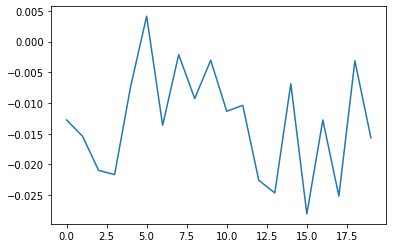

In [2]:
fitness = np.load('cma_lib_fitness10.npy')
plt.plot(fitness)

In [3]:
np.argsort(fitness)

array([15, 17, 13, 12,  3,  2, 19,  1,  6, 16,  0, 10, 11,  8,  4, 14, 18,
        9,  7,  5])

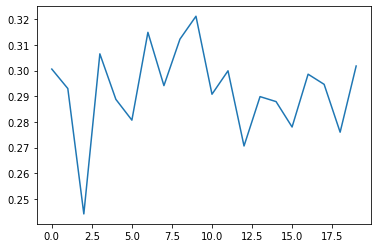

In [3]:
fitness = np.load('cma_reg_fitness10.npy')
plt.plot(fitness)

In [4]:
np.argsort(fitness)

array([ 2, 12, 18, 15,  5, 14,  4, 13, 10,  1,  7, 17, 16, 11,  0, 19,  3,
        8,  6,  9])

In [13]:
X_reg = np.load('cma_reg_res10.npy')

In [14]:
func_drag(X_reg[2])

three parts (321) of loss: 0.000, 0.000, -0.028
penalty:  0.232179194688797


(0.018600154668092728,
 tensor(-0.0278, device='cuda:0', grad_fn=<AddBackward0>))

In [10]:
X = np.load('cma_lib_res10.npy')
for x in X:
    print(func2d(torch.tensor(x).cuda(0)))

tensor(0.3423, device='cuda:0', dtype=torch.float64)
tensor(0.3169, device='cuda:0', dtype=torch.float64)
tensor(0.3433, device='cuda:0', dtype=torch.float64)
tensor(0.3409, device='cuda:0', dtype=torch.float64)
tensor(0.3874, device='cuda:0', dtype=torch.float64)
tensor(0.3562, device='cuda:0', dtype=torch.float64)
tensor(0.3167, device='cuda:0', dtype=torch.float64)
tensor(0.3508, device='cuda:0', dtype=torch.float64)
tensor(0.3594, device='cuda:0', dtype=torch.float64)
tensor(0.4036, device='cuda:0', dtype=torch.float64)
tensor(0.3380, device='cuda:0', dtype=torch.float64)
tensor(0.3737, device='cuda:0', dtype=torch.float64)
tensor(0.3864, device='cuda:0', dtype=torch.float64)
tensor(0.3386, device='cuda:0', dtype=torch.float64)
tensor(0.3351, device='cuda:0', dtype=torch.float64)
tensor(0.3745, device='cuda:0', dtype=torch.float64)
tensor(0.3506, device='cuda:0', dtype=torch.float64)
tensor(0.3411, device='cuda:0', dtype=torch.float64)
tensor(0.3185, device='cuda:0', dtype=torch.fl

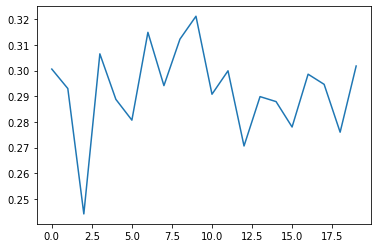

In [8]:
fitness_r = np.load('cma_reg_fitness10.npy')
plt.plot(fitness_r)

In [3]:
def load_pressure_predictor(load_directory):
    model = SplineCNN8Residuals(3)
    model.load_state_dict(torch.load(load_directory + "/cfdModel.nn"))
    return model.to("cuda:0").eval()

def load_latent_vectors(load_directory, checkpoint):
    filename = os.path.join(
        load_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(load_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"].cuda(0)

def load_decoder(load_directory, checkpoint):
    specs_filename = os.path.join(load_directory, "specs.json")
    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )
    specs = json.load(open(specs_filename))
    latent_size = specs["CodeLength"]
    decoder = Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(os.path.join(load_directory, checkpoint +".pth"))
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    decoder = decoder.module.cuda(0)
    decoder.eval()
    return decoder

In [4]:
from abc import ABC, abstractmethod

class objective_func(ABC):
    @abstractmethod
    def func(self, x):
        pass
    def dfunc(self, x):
        out = self.func(x)
        out.backward()
        return x.grad
    def get_optimal(self):
        return self.optimal
    def get_optimum(self):
        return self.optimum
    

class Decoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        latent_dropout=False,
    ):
        super(Decoder, self).__init__()

        def make_sequence():
            return []

        dims = [latent_size + 3] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x
class SplineBlock(nn.Module):
    def __init__(self, num_in_features, num_outp_features, mid_features, kernel=3, dim=3, batchnorm1=True):
        super(SplineBlock, self).__init__()
        self.batchnorm1 = batchnorm1
        self.conv1 = SplineConv(num_in_features, mid_features, dim, kernel, is_open_spline=False)
        if self.batchnorm1:
            self.batchnorm1 = torch.nn.BatchNorm1d(mid_features)
        self.conv2 = SplineConv(mid_features, 2 * mid_features, dim, kernel, is_open_spline=False)
        self.batchnorm2 = torch.nn.BatchNorm1d(2 * mid_features)
        self.conv3 = SplineConv(2 * mid_features + 3, num_outp_features, dim, kernel, is_open_spline=False)
  
    def forward(self, res, data):
        if self.batchnorm1:
            res = F.elu(self.batchnorm1(self.conv1(res, data['edge_index'], data['edge_attr'])))
        else:
            res = F.elu(self.conv1(res, data['edge_index'], data['edge_attr']))
        res = F.elu(self.batchnorm2(self.conv2(res, data['edge_index'], data['edge_attr'])))
#         res = F.elu(self.conv2(res, data.edge_index, data.edge_attr))
        res = torch.cat([res, data['x']], dim=1)
        res = self.conv3(res, data['edge_index'], data['edge_attr'])
        return res

class SplineCNN8Residuals(nn.Module):
    def __init__(self, num_features, kernel=3, dim=3):
        super(SplineCNN8Residuals, self).__init__()
        self.block1 = SplineBlock(num_features, 16, 8, kernel, dim)
        self.block2 = SplineBlock(16, 64, 32, kernel, dim)
        self.block3 = SplineBlock(64, 64, 128, kernel, dim)
        self.block4 = SplineBlock(64, 8, 16, kernel, dim)
        self.block5 = SplineBlock(11, 32, 16, kernel, dim)
        self.block6 = SplineBlock(32, 64, 32, kernel, dim)
        self.block7 = SplineBlock(64, 64, 128, kernel, dim)
        self.block8 = SplineBlock(75, 4, 16, kernel, dim)

    def forward(self, data):
        res = data['x']
        res = self.block1(res, data)
        res = self.block2(res, data)
        res = self.block3(res, data)
        res4 = self.block4(res, data)
        res = torch.cat([res4, data['x']], dim=1)
        res = self.block5(res, data)
        res = self.block6(res, data)
        res = self.block7(res, data)
        res = torch.cat([res, res4, data['x']], dim=1)
        res = self.block8(res, data)
        return res

def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4).cuda()

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() // N) % N
    samples[:, 0] = ((overall_index.long() // N) // N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False
    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda(0)
        num_subsample = min(max_batch, num_samples-head)
        latent_repeat = latent_vec.expand(num_subsample, -1)
        inputs = torch.cat([latent_repeat, sample_subset], 1)
        samples[head : min(head + max_batch, num_samples), 3] = \
                decoder(inputs).squeeze(1).detach()
        head += max_batch
        
    sdf_values = samples[:, 3].reshape(N, N, N).data

    return convert_sdf_samples_to_ply(
        sdf_values,
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )

def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.cpu().numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])
    norms_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])
        norms_tuple[i] = tuple(normals[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")
    el_norms = plyfile.PlyElement.describe(norms_tuple, "normals")

    ply_data = plyfile.PlyData([el_verts, el_faces, el_norms])
    return ply_data

def compute_lift_faces_diff(mesh, preds):
    pressures = torch.mean(preds[mesh['face'], 0], axis=0)

    # TODO: cahnge to x if needed
    pos = mesh['x']
    cross_prod = (pos[mesh['face'][1]] - pos[mesh['face'][0]]).cross(
                  pos[mesh['face'][2]] - pos[mesh['face'][0]])
    area = -cross_prod[:, 0] / 2
    lift = torch.mul(pressures, area)
    return torch.sum(lift[~torch.isnan(lift)])

def boundsLoss(points, box=[(-1, 1, 0)]):
    loss = 0
    for l, r, i in box:
        loss +=  torch.mean(F.relu(-points[:, i] + l))  \
               + torch.mean(F.relu( points[:, i] - r))
    return loss

def innerBoundsLoss(points, r=1, center=(0, 0, 0)):
    radiuses = torch.sum( (points - torch.Tensor(center).to('cuda:0')) ** 2 , dim=1)
    return torch.mean(F.relu(r - radiuses))

def calculate_loss(mesh, local_preds, constraint_rad=0.1):
    loss = compute_lift_faces_diff(mesh, local_preds)
    first = loss.clone().detach().cpu().numpy()
    loss += boundsLoss(mesh['x'], box=[(-0.6, 0.6, 0)])
    second = loss.clone().detach().cpu().numpy()
    loss += innerBoundsLoss(mesh['x'], r=constraint_rad**2, center=(-0.05, 0.05, 0))  \
          + innerBoundsLoss(mesh['x'], r=(constraint_rad / 2)**2, center=(0.3, 0, 0))
    print("three parts (321) of loss: %.3f, %.3f, %.3f"%(loss.detach().cpu().numpy() - second, second-first, first))
    return loss

def transformPoints(points, AvgTransform):
    matrix = torch.cuda.FloatTensor(AvgTransform).cuda(0)
    column = torch.zeros((len(points), 1), device="cuda:0") + 1
    stacked = torch.cat([points, column], dim=1)
    transformed = torch.matmul(matrix, stacked.t()).t()[:, :3]
    return transformed

def transform_mesh(points, ply_mesh, AvgTransform):
    transformed_points = transformPoints(points, AvgTransform)
    
    edges = trimesh.geometry.faces_to_edges(ply_mesh['face']['vertex_indices'])
    np_points = transformed_points.cpu().detach().numpy()
    edge_attr = [np_points[a] - np_points[b] for a, b in edges]
    mesh = {'x': transformed_points, 
        'face':torch.tensor(ply_mesh['face']['vertex_indices'], dtype=torch.long).to('cuda:0').t(),
        'edge_attr':torch.tensor(edge_attr, dtype=torch.float).to('cuda:0'),
        'edge_index':torch.tensor(edges, dtype=torch.long).t().contiguous().to('cuda:0')
        }
    return mesh


def decode_sdf(decoder, latent_vector, queries):
    num_samples = queries.shape[0]

    if latent_vector is None:
        inputs = queries
    else:
        latent_repeat = latent_vector.expand(num_samples, -1)
        inputs = torch.cat([latent_repeat, queries], 1)

    sdf = decoder(inputs)

    return sdf


def get_trimesh_from_torch_geo_with_colors(mesh, preds, vmin=-8, vmax=8):
    norm = mpl.colors.Normalize(vmin= vmin, vmax=vmax)
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    verticies = mesh['x'].cpu().detach()
    faces = mesh['face'].t().cpu().detach()
    return trimesh.Trimesh(vertices=verticies, faces=faces, 
                           vertex_colors=list(map(lambda c: m.to_rgba(c),  preds[:, 0].cpu().detach())))

In [5]:
DIR_to_load_data = '../Non-convex/starting_data'
experiment_directory = "data_for_this_experiments"

model = load_pressure_predictor(DIR_to_load_data)

decoder = load_decoder(DIR_to_load_data, "decoderModel")

latent_vectors = load_latent_vectors(DIR_to_load_data, "latentCodes").detach()

AvgTransform = np.load(DIR_to_load_data + "/avg_trans_matrix.npy") #computeAvgTransform()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
# /cvlabdata2/home/artem/Data/cars_remeshed_dsdf/transforms/"

In [6]:
#pca_result_20 = latent_vectors.squeeze()
#LATENT_KD_TREE_20d = KDTree(pca_result_20)

#pca_result_20_t = torch.tensor(pca_result_20, dtype=torch.float).cuda(0)
def func2d(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=10)
    return 0.2 * torch.sum((latent - latent_vectors[indeces.squeeze()]) ** 2, dim=1).mean() 

In [2]:
N = 256
IN_N = 15

def func_drag(latent):
    start = time.time()
    latent = torch.tensor(latent, dtype=torch.float).cuda(0).reshape(1,-1)
    with torch.no_grad():
        ply_mesh = create_mesh(decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)
    #print("************out of space***********", e)
    points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                      ply_mesh['vertex']['y'][:, None], 
                                      ply_mesh['vertex']['z'][:, None]))).cuda(0)
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=0.05)
    apenalty = func2d(latent)
    end = time.time()
    print("iter time: ", end-start)
    print("penalty: ", 0.2*apenalty.item())
    print("full: ", (loss + 0.2*apenalty).item())
    return (loss + 0.2*apenalty).item()

def func_grad(latent):
    #try:
    start = time.time()
    with torch.no_grad():
        ply_mesh = create_mesh(decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)
    end = time.time()
    print("mesh time: ", end-start)
   # except Exception as e:
   #     raise e
   #     print("************out of space***********", e)
    points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                      ply_mesh['vertex']['y'][:, None], 
                                      ply_mesh['vertex']['z'][:, None]))).cuda(0)
    points.requires_grad = True
    sdf_value = decode_sdf(decoder, latent.detach(), points)
    sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda(0))
    
    initial_dir = points.grad.clone()
    points.grad.data.zero_()
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=0.05)
    loss.backward()
    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    multipliers = torch.cuda.FloatTensor(sign).cuda(0)
    sdf_value = torch.squeeze(decode_sdf(decoder, latent, points.detach()))
    final_loss = torch.sum(sdf_value * multipliers)
    apenalty = func2d(latent)
    final = time.time()
    print("iter time: ", final-start)
    print("penalty: ", 0.2*apenalty.item())
    print("full: ", (loss + 0.2*apenalty).item())
    return (loss + 0.2*apenalty).item()

def inner_opt(x, Xs):
    x = torch.tensor(x, dtype=torch.float).cuda(0).requires_grad_(True)
    opt = torch.optim.SGD([x], lr=0.2)
    i = 0
    while i < IN_N:
        loss = func_grad(x)
        loss.backward()
        
        Xs.append(x.clone().cpu().detach().numpy())
        losses.append(loss.item())
        
        opt.step()
        opt.zero_grad()
        i += 1
        if i == IN_N:
            fit = loss.item()
        np.save("../Compare_optimisers/new_cma_sgd/cma_sgd_noReg.npy", Xs)
        np.save("../Compare_optimisers/new_cma_sgd/cma_sgd_fitness_noReg.npy", fits)
    print("one time is done", len(Xs), "\n")
    return x, fit

In [10]:
x0, sigma0 = latent_vectors[32].cpu().numpy(), 0.05
%time inner_opt(x0)

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 11.91 GiB total capacity; 8.70 GiB already allocated; 20.50 MiB free; 8.81 GiB reserved in total by PyTorch)

In [ ]:
x0, sigma0 = latent_vectors[32].cpu().numpy(), 0.05
es = cma.CMAEvolutionStrategy(x0, sigma0)
i = 0
Xs = []
fits = []
while i < 20:
    X = es.ask()
    new_x_fit = [inner_opt(x, Xs, fits) for x in X]
    X, fitness = zip(*new_x_fit)
    #Xs.append(X)
    #fits.append(fitness)
    es.tell(X, fitness)
    es.disp(1)
    i += 1

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 256 (seed=476735, Sun Sep  6 11:44:47 2020)
mesh time:  11.231570482254028
three parts (321) of loss: 0.000, 0.000, 0.088
iter time:  44.692142724990845
mesh time:  11.037013053894043
three parts (321) of loss: 0.000, 0.000, 0.092
iter time:  45.08275365829468
mesh time:  11.094297647476196
three parts (321) of loss: 0.000, 0.000, 0.090
iter time:  47.36536717414856
mesh time:  10.94363284111023
three parts (321) of loss: 0.000, 0.000, 0.085
iter time:  47.06889510154724
mesh time:  11.101743936538696
three parts (321) of loss: 0.000, 0.000, 0.084
iter time:  46.3037486076355
mesh time:  11.084283590316772
three parts (321) of loss: 0.000, 0.000, 0.085
iter time:  46.233688831329346
mesh time:  10.94188404083252
three parts (321) of loss: 0.000, 0.000, 0.088
iter time:  45.968669176101685
mesh time:  10.97279977798462
three parts (321) of loss: 0.000, 0.000, 0.091
iter time:  43.383126974105835
mesh time:  10.976881504058838
three parts

iter time:  42.76652956008911
one time is done
mesh time:  10.926191329956055
three parts (321) of loss: 0.000, 0.000, 0.077
iter time:  41.594197511672974
mesh time:  10.782216548919678
three parts (321) of loss: 0.000, 0.000, 0.075
iter time:  41.27386784553528
mesh time:  10.881051778793335
three parts (321) of loss: 0.000, 0.000, 0.073
iter time:  41.115952491760254
mesh time:  10.846125602722168
three parts (321) of loss: 0.000, 0.000, 0.075
iter time:  40.778332471847534
mesh time:  10.828755378723145
three parts (321) of loss: 0.000, 0.000, 0.074
iter time:  40.25202393531799
mesh time:  10.770756244659424
three parts (321) of loss: 0.000, 0.000, 0.067
iter time:  39.48277759552002
mesh time:  10.764060258865356
three parts (321) of loss: 0.000, 0.000, 0.059
iter time:  38.822816371917725
mesh time:  10.775565385818481
three parts (321) of loss: 0.000, 0.000, 0.056
iter time:  38.32850694656372
mesh time:  10.730133056640625
three parts (321) of loss: 0.000, 0.000, 0.051
iter ti

iter time:  41.81657433509827
one time is done
mesh time:  10.82440733909607
three parts (321) of loss: 0.000, 0.000, 0.065
iter time:  40.139591217041016
mesh time:  10.817459106445312
three parts (321) of loss: 0.000, 0.000, 0.065
iter time:  39.938133239746094
mesh time:  10.817028284072876
three parts (321) of loss: 0.000, 0.000, 0.064
iter time:  39.477200508117676
mesh time:  10.903670072555542
three parts (321) of loss: 0.000, 0.000, 0.063
iter time:  39.5019109249115
mesh time:  10.874709844589233
three parts (321) of loss: 0.000, 0.000, 0.062
iter time:  39.21732759475708
mesh time:  10.81610918045044
three parts (321) of loss: 0.000, 0.000, 0.061
iter time:  38.942925691604614
mesh time:  10.840548515319824
three parts (321) of loss: 0.000, 0.000, 0.057
iter time:  39.00207996368408
mesh time:  10.834455251693726
three parts (321) of loss: 0.000, 0.000, 0.053
iter time:  38.869744300842285
mesh time:  10.826317071914673
three parts (321) of loss: 0.000, 0.000, 0.051
iter time

In [ ]:
x0, sigma0 = latent_vectors[32].cpu().numpy(), 0.05
es = cma.CMAEvolutionStrategy(x0, sigma0)
i = 0
Xs = []
fits = []
pure_drags = []
while i < 50:
    X = es.ask()
    fitness = [func_drag(x) for x in X]
    es.tell(X, fitness)
    Xs.append(X)
    fits.append(fitness)
    #pure_drags.append(pure_drag)
    np.save("../Compare_optimisers/new_cma/cma_noReg.npy", Xs)
    np.save("../Compare_optimisers/new_cma/cam_fitness_noReg.npy", fits)
    #pure_drags.save("../Compare_optimisers/new_cma/cma_pure_drag_noReg.npy")
    es.disp(1)
    i += 1

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 256 (seed=464154, Sun Sep  6 02:57:00 2020)
three parts (321) of loss: 0.000, 0.000, 0.081
penalty:  0.00071333022788167
full:  0.0814691036939621
three parts (321) of loss: 0.000, 0.000, 0.075
penalty:  0.0006610580021515489
full:  0.07511799782514572
three parts (321) of loss: 0.000, 0.000, 0.070
penalty:  0.0008092412608675659
full:  0.06967207044363022
three parts (321) of loss: 0.000, 0.000, 0.067
penalty:  0.0007675704546272755
full:  0.06713323295116425
three parts (321) of loss: 0.000, 0.000, 0.068
penalty:  0.0007870035478845239
full:  0.06839330494403839
three parts (321) of loss: 0.000, 0.000, 0.075
penalty:  0.0007083148811943829
full:  0.07501015812158585
three parts (321) of loss: 0.000, 0.000, 0.091
penalty:  0.0007236588280647993
full:  0.09162437170743942
three parts (321) of loss: 0.000, 0.000, 0.080
penalty:  0.0008530745399184525
full:  0.08052310347557068
three parts (321) of loss: 0.000, 0.000, 0.080
penalty:  0.00

In [23]:
np.save("cma_reg_res10.npy", X)
np.save("cma_reg_fitness10.npy", fitness)

In [18]:
np.load("../Compare_optimisers/new_cma/cam_fitness_noReg.npy")

array([[ 8.14691037e-02,  7.51179978e-02,  6.96720704e-02,
         6.71332330e-02,  6.83933049e-02,  7.50101581e-02,
         9.16243717e-02,  8.05231035e-02,  8.06443095e-02,
         8.70581195e-02,  9.17790458e-02,  1.03241332e-01,
         7.62127116e-02,  7.09038600e-02,  6.16212972e-02,
         6.70503154e-02,  6.63675442e-02,  8.69827569e-02,
         5.58323003e-02,  5.44632375e-02],
       [ 4.59464341e-02,  6.94521815e-02,  6.90681711e-02,
         7.61268660e-02,  4.55352962e-02,  8.61483142e-02,
         3.91728058e-02,  5.82517870e-02,  7.88400620e-02,
         6.12445362e-02,  7.70423040e-02,  6.33215234e-02,
         5.65932691e-02,  6.43090531e-02,  5.90235926e-02,
         5.87146059e-02,  6.00616299e-02,  5.81902415e-02,
         4.52937819e-02,  8.08732510e-02],
       [ 4.63356599e-02,  4.96247448e-02,  3.78423557e-02,
         6.05475381e-02,  1.97000448e-02,  5.47634698e-02,
         6.59596696e-02,  7.74440095e-02,  4.00840119e-02,
         3.65953259e-02,  6.5